In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display

In [3]:
torch.cuda.empty_cache()

### Loading the dataset

set up dataloader

In [5]:
path = '/usr0/home/tianjunm/datasets/processed/mixer/5-10-2000-4/test';
# d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 690)))
d = ds.SignalDataset(root_dir=path, transform=ds.ToTensor(size=(129, 690)))

In [9]:
dataloader = torch.utils.data.DataLoader(d, batch_size=4, shuffle=False)

In [10]:
for i, info in enumerate(dataloader):
    aggregate = info['aggregate']
#     ground_truths_in = info['ground_truths_in']
#     ground_truths_gt = info['ground_truths_gt']
    ground_truths = info['ground_truths']
    
    break

# _, seq_len, input_dim = aggregate.shape
print(aggregate.shape)
print(ground_truths.shape)
# print(ground_truths_in.shape)
# print(ground_truths_gt.shape)

torch.Size([3, 2, 690, 129])
torch.Size([3, 690, 5, 258])


In [31]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)
    
def get_spect(data):
    r = np.split(data.numpy().T, 2)[0]
    i = np.split(data.numpy().T, 2)[1]
    c = r + 1j * i
    
    return c, scipy.signal.istft(c, fs=44100, nfft = 256)

def get_agg_spect(data):
    r = data[0].numpy().T
    i = data[1].numpy().T
    c = (r + i)

    return c, scipy.signal.istft(c, fs=44100, nfft = 256)

visualize sample data

In [43]:
agg_sample = aggregate[0]
c_agg, (fs, data) = get_agg_spect(agg_sample)

gt_1 = ground_truths[0, :, 0, :]
gt_2 = ground_truths[0, :, 1, :]
gt_3 = ground_truths[0, :, 2, :]
c_gt1, gt1_data = get_spect(gt_1)
c_gt2, gt2_data = get_spect(gt_2)
c_gt3, gt3_data = get_spect(gt_3)

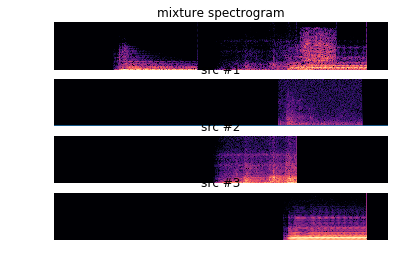

In [44]:
plt.subplot(4, 1, 1)
plt.title('mixture spectrogram')
plt.axis('off')
display(c_agg, 22050*8)
plt.subplot(4, 1, 2)
plt.title('src #1')
plt.plot(data)
plt.axis('off')
display(c_gt1, 22050*8)
plt.subplot(4, 1, 3)
plt.title('src #2')
plt.axis('off')
display(c_gt2, 22050*8)
plt.subplot(4, 1, 4)
plt.title('src #3')
plt.axis('off')
display(c_gt3, 22050*8)

# print(np.array_equal(gin_1[1:], gt_1))

In [62]:
IPython.display.Audio(data=gt1_data, rate=44100)

In [49]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

# _, rdata = scipy.signal.istft(c, fs=44100, nfft = 256)
# IPython.display.Audio(data=rdata, rate=44100)

transformer model

In [50]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [54]:
import model.transformer
_, _, seq_len, input_dim = aggregate.shape
print(seq_len)
print(input_dim)

net = model.models.LookListen_Base(seq_len=seq_len, input_dim=input_dim).to(device)

net.load_state_dict(torch.load('pretrained/google_checkpoint_euclidean_5-10_0(250).pth'))
net.eval()

690
129


LookListen_Base(
  (convs): ModuleList(
    (0): Conv2d(2, 6, kernel_size=(1, 7), stride=(1, 1), padding=[0, 3])
    (1): Conv2d(6, 6, kernel_size=(7, 1), stride=(1, 1), padding=[3, 0])
    (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[4, 4], dilation=(2, 2))
    (4): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[8, 8], dilation=(4, 4))
    (5): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[16, 16], dilation=(8, 8))
    (6): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
  )
  (bns): ModuleList(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2

In [56]:
preds, _ = net(aggregate.to(device))
# preds = net(aggregate.to(device), ground_truths.to(device), None, subseq_mask)
print(aggregate.shape)
print(preds.shape)
# preds2, _ = net2(aggregate)

torch.Size([3, 2, 690, 129])
torch.Size([3, 690, 2, 258])


aggregate

In [32]:
_, data = scipy.signal.istft(c_agg, fs=44100, nfft = 256)
IPython.display.Audio(data=data, rate=44100)

predicted separations

In [61]:
_, rdata = scipy.signal.istft(c1, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [63]:
_, rdata = scipy.signal.istft(c2, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [ ]:
_, rdata = scipy.signal.istft(c3, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [ ]:
d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

Google look to listen baseline

In [ ]:
for i, info in enumerate(dataloader):
#     print(i)
    aggregate = info['aggregate']
    ground_truths = info['ground_truths']
    break

In [ ]:
bs, num_channels, seq_len, input_dim = aggregate.size()
net3 = model.models.LookListen_Base(input_dim=input_dim, seq_len=seq_len, num_sources=num_channels)

net3.load_state_dict(torch.load('pretrained_range10/google_checkpoint_euclidean_0_245.pth'))
net3.eval()

In [ ]:
preds3, _ = net3(aggregate)

testing model optimization

In [ ]:
preds_cmp = preds.view(4, seq_len + 1, 2, 258)[:, :-1]
preds_cmp.shape

In [ ]:
criterion = model.models.MinLoss(device, metric='euclidean')

In [ ]:
loss = criterion(preds_cmp.to(device), ground_truths_gt.to(device))
loss

In [ ]:
loss.backward()

In [ ]:
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer.step()
# preds2 = net(aggregate)

In [12]:
seps = model.transformer.greedy_decoder(net, aggregate.to(device), seq_len, 2, freq_range, device)

In [ ]:
print(seps.shape)
pp = seps.view(-1, seq_len, 2, 258)

(0.0, 2.0027210884353743, 0.0, 11025.0)

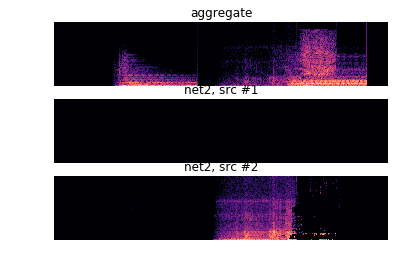

In [60]:
pp = preds
xid = 0
a = aggregate[xid]
g1 = pp[xid, :, 0, :].cpu().detach().numpy().T
g2 = pp[xid, :, 1, :].cpu().detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
plt.title('aggregate')
display(c_agg, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('net2, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('net2, src #2')
display(c2, 22050*8)
plt.axis('off')

random experiments

In [ ]:
a = torch.arange(12).view(4, 3)
a1 = a[:2].view(-1, 3)
a2 = a[2:].view(-1, 3)

print(a1)
print(a2)

print(torch.cat([a1, a2]))
print(torch.cat([a1, a2]).shape)
# print(a.sha)

In [ ]:
aa = torch.arange(12.).view(3, 4)
a = aa.view(4, 3)
# b = torch.ones(4, 3).copy_(a)
b = torch.cat([torch.ones(3).view(1,3), a])

print(aa)
print(a)
print(b)
aa.fill_(10)
print(a)
print(b)


In [ ]:
torch.ones(2, 3)
torch.zeros(2, 3)

In [ ]:

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)